In [3]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [16]:
%matplotlib inline
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.show()

In [17]:
DATA_DIR = "../data/Output"

In [18]:
iris = cv2.imread(f"{DATA_DIR}/NormalizedImages/0000_000_imno.bmp", cv2.IMREAD_GRAYSCALE)

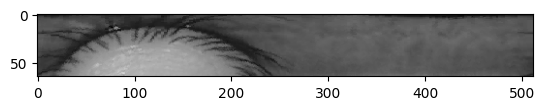

In [19]:
imshow(iris)

In [11]:
mask = cv2.imread(f"{DATA_DIR}/NormalizedMasks/0000_000_mano.bmp", cv2.IMREAD_GRAYSCALE)

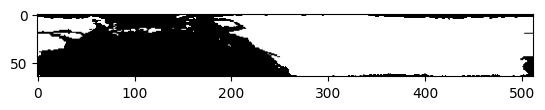

In [12]:
imshow(mask)

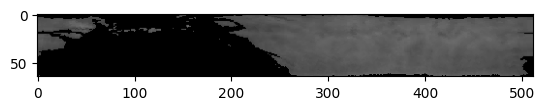

In [13]:
imshow(iris & mask)

In [20]:
iris_code = cv2.imread(f"{DATA_DIR}/IrisCodes/0000_000_code.bmp", cv2.IMREAD_GRAYSCALE)

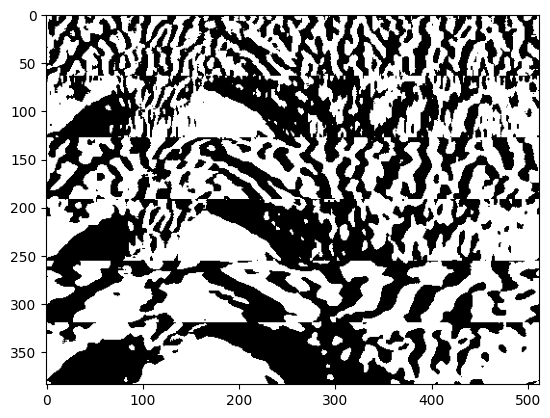

In [21]:
imshow(iris_code)

In [22]:
def read_ap_img(path, shape):
    ap = np.zeros(shape, dtype=np.uint8)
    
    with open(path, "r") as f:
        n_points = int(f.readline())
        for i in range(n_points):
            x, y = f.readline().split()
            x = int(x)
            y = int(y)
            ap[x][y] = 255
        
    return ap

In [23]:
ap = read_ap_img("points.txt", iris.shape)

In [24]:
def read_ap_indices(path):
    points = []
    
    with open(path, "r") as f:
        n_points = int(f.readline())
        for i in range(n_points):
            x, y = f.readline().split()
            x = int(x)
            y = int(y)
            for i in range(1, 7):
                points.append([x*i, y])
            
    # Transform it in a way to be used for numpy arrays like this: x[ap_indices]
    points = tuple(np.array(points).T.tolist())
        
    return points

In [25]:
ap_indices = read_ap_indices("points.txt")

In [36]:
iris2 = cv2.imread(f"{DATA_DIR}/NormalizedImages/0001_001_imno.bmp", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(f"{DATA_DIR}/NormalizedMasks/0001_001_mano.bmp", cv2.IMREAD_GRAYSCALE)
iris_code2 = cv2.imread(f"{DATA_DIR}/IrisCodes/0001_001_code.bmp", cv2.IMREAD_GRAYSCALE)

In [37]:
total_mask = mask & mask2 & ap
total_mask_big = np.array(total_mask.tolist() * 6)

In [38]:
import numpy as np
import concrete.numpy as cnp

In [39]:
def hamming_distance(x, y) -> int:
    return np.sum(x ^ y)

In [40]:
def match_iris(iris1, iris2, mask) -> int:
    return hamming_distance(iris1 & mask, iris2 & mask)

In [41]:
ic_ap = iris_code[ap_indices]
ic2_ap = iris_code2[ap_indices]
m_ap = total_mask_big[ap_indices]

In [42]:
match_iris(iris_code, iris_code2, total_mask_big)

103785

In [43]:
match_iris(ic_ap, ic2_ap, m_ap)

53805

In [23]:
class IrisMatcher:
    def __init__(self, inputset) -> None:
        self.inputset = inputset

        self.configuration = cnp.Configuration(
            enable_unsafe_features=True,
            use_insecure_key_cache=True,
            insecure_key_cache_location=".keys",
        )

        self.compiler = cnp.Compiler(match_iris, {"iris1": "encrypted", "iris2": "encrypted", "mask": "encrypted"})
        self.circuit = self.compiler.compile(self.inputset, self.configuration)

In [24]:
match_iris(iris_code, iris_code2, total_mask_big)

38505

In [25]:
%%time
iris_matcher = IrisMatcher([(ic_ap, ic2_ap, m_ap)])

CPU times: user 4.57 s, sys: 211 ms, total: 4.78 s
Wall time: 5.73 s


In [27]:
print(iris_matcher.circuit)

%0 = iris1                      # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%1 = iris2                      # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%2 = mask                       # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%3 = bitwise_and(%0, %2)        # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%4 = bitwise_and(%1, %2)        # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%5 = bitwise_xor(%3, %4)        # EncryptedTensor<uint8, shape=(1536,)>        ∈ [0, 255]
%6 = sum(%5)                    # EncryptedScalar<uint15>                      ∈ [20400, 20400]
return %6


In [28]:
iris_matcher.circuit.client.save("client.zip")

In [29]:
iris_matcher.circuit.server.save("server.zip")

In [30]:
client = cnp.Client.load("client.zip")

In [33]:
server = cnp.Server.load("server.zip")

In [35]:
client.encrypt(iris_code)

ValueError: Expected 3 inputs but got 1

In [48]:
%%time
iris_matcher.circuit.keygen()

CPU times: user 5min 45s, sys: 1.89 s, total: 5min 47s
Wall time: 48.5 s


KeySetCache: miss, regenerating .keys/11912898147308900244/0_0


In [50]:
%%time
iris_matcher.circuit.encrypt(ic_ap, ic2_ap, m_ap)

CPU times: user 3.54 s, sys: 171 ms, total: 3.71 s
Wall time: 3.68 s


In [ ]:
%%time
iris_matcher.circuit.encrypt_run_decrypt(ic_ap, ic2_ap, m_ap)

In [115]:
best_shifted_hamming_distance(iris_code & total_mask_big, iris_code2 & total_mask_big) / np.sum(total_mask_big)

0.15928270042194093

In [116]:
iris10 = cv2.imread(f"{DATA_DIR}/NormalizedImages/0001_000_imno.bmp", cv2.IMREAD_GRAYSCALE)
mask10 = cv2.imread(f"{DATA_DIR}/NormalizedMasks/0001_000_mano.bmp", cv2.IMREAD_GRAYSCALE)
iris_code10 = cv2.imread(f"{DATA_DIR}/IrisCodes/0001_000_code.bmp", cv2.IMREAD_GRAYSCALE)

In [117]:
total_mask = mask & mask10 & ap

In [118]:
total_mask_big = np.array(total_mask.tolist() * 6)

In [119]:
best_shifted_hamming_distance(iris_code & total_mask_big, iris_code10 & total_mask_big) / np.sum(total_mask_big)

0.47368421052631576

In [120]:
iris11 = cv2.imread(f"{DATA_DIR}/NormalizedImages/0001_001_imno.bmp", cv2.IMREAD_GRAYSCALE)
mask11 = cv2.imread(f"{DATA_DIR}/NormalizedMasks/0001_001_mano.bmp", cv2.IMREAD_GRAYSCALE)
iris_code11 = cv2.imread(f"{DATA_DIR}/IrisCodes/0001_001_code.bmp", cv2.IMREAD_GRAYSCALE)

In [121]:
total_mask = mask10 & mask11 & ap

In [122]:
total_mask_big = np.array(total_mask.tolist() * 6)

In [123]:
best_shifted_hamming_distance(iris_code10 & total_mask_big, iris_code11 & total_mask_big) / np.sum(total_mask_big)

0.19032921810699588